# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении имеем исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Для дальнейше работы необходимо:
1. исправить оформления заглавий колонок
2. Изменять тип DateCrawled, LastSeen, DateCreated на datetime нет необходимости, так в будущем эти столбцы для обучения не понадобятся

In [5]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [6]:
df = df.rename(columns = {'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 
                          'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 
                          'Kilometer': 'kilometer', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 
                          'Brand': 'brand', 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 
                          'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

In [7]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Обнаружено много пропусков (окло 20% от всех данных). Удаление пропусков приведёт к потерям множества нужных данных. В связи с этим необходимо восполнить пропуски. Столбцы fuel_type, vehicle_type, gearbox будут заполнены по методу большинства. Столбец model будет заполнена по методу большинства исходя из большинства колонок той же фирмы автомобиля. Столбец not_repaired будет заполнен как 'no', так как скорее всего машина в ремонте не была.

In [8]:
df['not_repaired'] = df['not_repaired'].fillna('no')
df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type'].mode().values[0])
df['vehicle_type'] = df['vehicle_type'].fillna(df['vehicle_type'].mode().values[0])
df['gearbox'] = df['gearbox'].fillna(df['gearbox'].mode().values[0])


In [9]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
not_repaired              0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [10]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [11]:
brands = ['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada']
for i in brands:
    df.loc[df['brand'] == i, 'model'] = df.loc[df['brand'] == i, 'model'].fillna(df['model'].mode()[0])
        

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> 👍</font>

In [12]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [13]:
df.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,no,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [14]:
list_col = ['gearbox', 'model', 'fuel_type', 'brand']
for i in list_col:
    df[i] = df[i].str.lower()

In [15]:
df.duplicated().sum()

5

In [16]:
df[df.duplicated(keep=False)].sort_values(by='price').head(20)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
189060,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,gasoline,audi,no,2016-04-04 00:00:00,0,65428,2016-04-05 12:30:14
194008,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,gasoline,audi,no,2016-04-04 00:00:00,0,65428,2016-04-05 12:30:14


In [17]:
df = df.drop_duplicates()

In [18]:
df.duplicated().sum()

0

Датафрейм очищен от дубликатов.

In [19]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Замечания в данных**
1. размах цен слишком большой и имеет высокий уровень стандартного отклонения. Необходимо будет избавиться от выбросов.
2. дата регистрации начинается с 1000 года и заканчивается 9999 годом. обозначим интервал следующим образом: от 1946 года (жёлтые номера образца 1946 года, которые могут встретиться на ретроавтомобилях) до 2022 года.
3. Лошадиные силы у автомобиля достигают 20000. Согласно [рейтингу самых мощных автомобилей в мире](https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire) количество лошадиных сил не может превышать 5000. А вторая машина по мощноти имеет 2500 л.с. Эта цифра и будет нашей верхней границей, так как моделей с самой сильной мощностью всего 3 в мире, а выбросов только по России гораздо больше.
3. Месяц регистрации автомобилей равный 0 присвоим значение 1.
4. Столбцы "number_of_pictures", "date_crawled","date_created","last_seen","postal_code" удалим, так как они не содержат в себе полезную информацию, влияющую на стоимость автомобиля.

In [20]:
df = df.drop(["number_of_pictures", "date_created","last_seen","postal_code"], 1) # "date_crawled"

In [21]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [22]:
df.loc[df['registration_month'] == 0, 'registration_month'] = 1

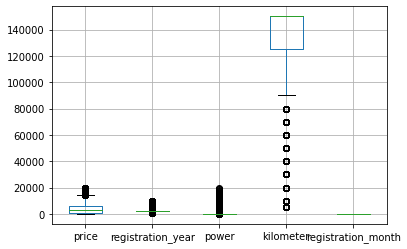

In [23]:
df.boxplot()
plt.show()

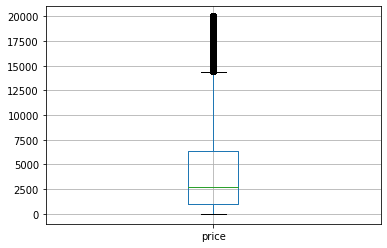

In [24]:
df.boxplot('price')
plt.show()

In [25]:
df[df['price'] > 14000].head(20)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no
33,2016-03-25 21:48:47,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no
50,2016-03-30 08:50:37,14800,convertible,2008,manual,170,1er,125000,4,petrol,bmw,no
64,2016-03-07 22:36:54,14999,convertible,2007,manual,218,3er,50000,8,petrol,bmw,no
93,2016-03-10 11:44:54,14500,small,2013,manual,86,a1,60000,4,petrol,audi,no
134,2016-03-21 16:45:30,14499,sedan,2007,auto,170,c_klasse,125000,5,gasoline,mercedes_benz,no
155,2016-03-09 12:53:53,14500,sedan,2017,manual,136,sportage,125000,5,gasoline,kia,no
172,2016-03-07 12:38:19,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no


Согласно данным из диаграммы размаха можно сделать вывод, что выбросами считается показатель стоимости, превышающий 14000.

In [26]:
size_before = df.shape[0]

In [27]:
df = df[df['price'] < 14000]

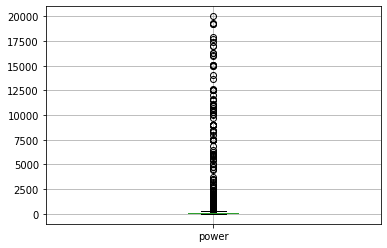

In [28]:
df.boxplot(column='power')
plt.show()

In [29]:
df = df[df['power'] <= 2500]

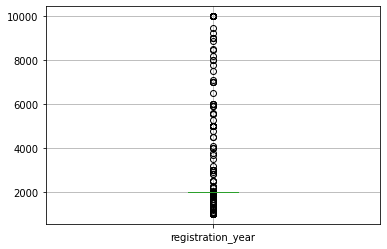

In [30]:
df.boxplot('registration_year')
plt.show()

In [31]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,1,petrol,volkswagen,no
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [32]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format = '%Y-%m-%d %H:%M:%S')

In [33]:
df['date_crawled'] = df['date_crawled'].dt.year

In [34]:
df[['registration_year', 'date_crawled']]

,registration_year,date_crawled
0,1993,2016
2,2004,2016
3,2001,2016
4,2008,2016
5,1995,2016
...,...,...
354364,2005,2016
354365,2005,2016
354366,2000,2016
354367,1996,2016


In [35]:
df[df['registration_year'] > df['date_crawled']].count()

date_crawled          14177
price                 14177
vehicle_type          14177
registration_year     14177
gearbox               14177
power                 14177
model                 14177
kilometer             14177
registration_month    14177
fuel_type             14177
brand                 14177
not_repaired          14177
dtype: int64

В датасете есть автомобили, регистрация которых была позже чем выгрузка из базы данных. В связи с этим необходимо прировнять все ошибочные даты регистрации автомобиля к дате выгрузки данных.

In [36]:
df.loc[df['registration_year'] > df['date_crawled'], 'registration_year'] = df.loc[df['registration_year'] > df['date_crawled'], 'date_crawled']

In [37]:
df[df['registration_year'] > df['date_crawled']].count()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64

In [38]:
df = df.drop('date_crawled', 1)

In [39]:
df = df[(df['registration_year'] > 1946)&(df['registration_year'] <= 2022)]

In [40]:
size_after = df.shape[0]

In [41]:
print('После очистки датасета от выбросов общая доль потерь в данных составила:', 1 - size_after / size_before)

После очистки датасета от выбросов общая доль потерь в данных составила: 0.05788398370037584


In [42]:
df.corr()

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.372590,0.374758,-0.265552,0.108602
registration_year,0.372590,1.000000,0.064363,-0.150535,0.038529
power,0.374758,0.064363,1.000000,0.110922,0.100297
kilometer,-0.265552,-0.150535,0.110922,1.000000,0.015282
registration_month,0.108602,0.038529,0.100297,0.015282,1.000000


### Разделение данных и их кодировка

In [43]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,1,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


Поскольку модели машинного обучения могут обрабатывать только числовые данные, то нужно все категориальные данные перевести в числовые.

In [44]:
df_tree = pd.get_dummies(df, drop_first=True)
df_linear = pd.get_dummies(df, drop_first=True)

In [45]:
# код ревьюера
df_tree.head()

,price,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
0,480,1993,0,150000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [46]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,1,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [47]:
df_xgb = df.copy()
df_xgb = df_xgb.astype({
    'vehicle_type': 'category',
    'gearbox': 'category',
    'model': 'category',
    'fuel_type': 'category',
    'brand': 'category',
    'not_repaired': 'category'
})
df = df_xgb

In [48]:
train = df.drop('price', 1)
target = df['price']
train_xgb = df_xgb.drop('price', 1)
target_xgb = df_xgb['price']
train_tree = df_tree.drop('price', 1)
target_tree = df_tree['price']
train_lin = df_linear.drop('price', 1)
target_lin = df_linear['price']

In [49]:
train_features,test_features, train_target, test_target = train_test_split(train, target, test_size=0.25, random_state=12345)
train_features_xgb,test_features_xgb, train_target_xgb, test_target_xgb = train_test_split(train_xgb, target_xgb, test_size=0.25, random_state=12345)
train_features_tree,test_features_tree, train_target_tree, test_target_tree = train_test_split(train_tree, target_tree, test_size=0.25, random_state=12345)
train_features_lin,test_features_lin, train_target_lin, test_target_lin = train_test_split(train_lin, target_lin, test_size=0.25, random_state=12345)

In [50]:
train_features.shape[0]

250389

In [51]:
train_target.shape[0]

250389

**Выводы**

бнаружено много пропусков (окло 20% от всех данных). Удаление пропусков приведёт к потерям множества нужных данных. В связи с этим необходимо восполнить пропуски. Столбцы fuel_type, vehicle_type, gearbox будут заполнены по методу большинства. Столбец model будет заполнена по методу большинства исходя из большинства колонок той же фирмы автомобиля. Столбец not_repaired будет заполнен как 'no', так как скорее всего машина в ремонте не была.
Датафрейм очищен от дубликатов.

**Замечания в данных**
1. размах цен слишком большой и имеет высокий уровень стандартного отклонения. Необходимо будет избавиться от выбросов.
2. дата регистрации начинается с 1000 года и заканчивается 9999 годом. обозначим интервал следующим образом: от 1900 года до 2022 года.
3. Лошадиные силы у автомобиля достигают 20000. Согласно [рейтингу самых мощных автомобилей в мире](https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire) количество лошадиных сил не может превышать 5000. А вторая машина по мощноти имеет 2500 л.с. Эта цифра и будет нашей верхней границей, так как моделей с самой сильной мощностью всего 3 в мире, а выбросов только по России гораздо больше.
3. Месяц регистрации автомобилей равный 0 присвоим значение 1.
4. Столбцы "number_of_pictures", "date_crawled","date_created","last_seen","postal_code" удалим, так как они не содержат в себе полезную информацию, влияющую на стоимость автомобиля.

Согласно данным из диаграммы размаха можно сделать вывод, что выбросами считается показатель стоимости, превышающий 14000.

После очистки датасета от выбросов общая доль потерь в данных составила: 0.058160535494576227

Поскольку модели машинного обучения могут обрабатывать только числовые данные, то нужно все категориальные данные перевести в числовые. Разделим исходную выборку на обучающую и тестовую в пропорции 75% на 25%.

## Анализ моделей

In [77]:
model_list = ['Tree', 'Forest', 'LR', 'LightGBM', 'Catboost']
learn_predict_list = [['13 min', '10 min', '32 s', '8.17 s', '3 min'], ['209 ms', '354 ms', '389 ms', '1.39 s', '585 ms'], [1608, 1570, 2339, 1490, 1431]]


In [53]:
param_set = {
    'random_state': [12345],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_set, cv=3, scoring= 'neg_root_mean_squared_error')


Время обучения дерева решений

In [54]:
%%time
grid_search.fit(train_features_tree, train_target_tree)

CPU times: user 8min 56s, sys: 4min 43s, total: 13min 40s
Wall time: 13min 56s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error')

время предсказания модели дерева решений

In [55]:
%%time
best_model = grid_search.best_estimator_
predict = best_model.predict(test_features_tree)

CPU times: user 141 ms, sys: 66.7 ms, total: 208 ms
Wall time: 209 ms


In [56]:
print('Лучший показатель rmse у модели дерева решений:', mean_squared_error(test_target_tree, predict, squared=False))

Лучший показатель rmse у модели дерева решений: 1608.332951184132


In [57]:
param_set = {
    'max_depth': [10, 30, 50],
    'n_estimators': [4],
    'random_state':[12345]
}
    
model = RandomForestRegressor(random_state=12345)

gscv_forest = GridSearchCV(estimator=model, param_grid=param_set, cv=5)

Время обучения

In [58]:
%%time
gscv_forest.fit(train_features_tree, train_target_tree)

CPU times: user 5min 54s, sys: 4min 34s, total: 10min 29s
Wall time: 10min 37s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [10, 30, 50], 'n_estimators': [4],
                         'random_state': [12345]})

время предсказания модели случайного леса

In [59]:
%%time
best_model = gscv_forest.best_estimator_
predictions = best_model.predict(test_features_tree)

CPU times: user 282 ms, sys: 62.9 ms, total: 345 ms
Wall time: 354 ms


In [60]:
print('Лучший показатель rmse у случайного леса равен', mean_squared_error(test_target_tree, predictions, squared=False))

Лучший показатель rmse у случайного леса равен 1570.591072962454


In [61]:
model = LinearRegression()


Время обучения линейной регрессии

In [62]:
%%time
model.fit(train_features_lin, train_target_lin)

CPU times: user 24.2 s, sys: 7.8 s, total: 32 s
Wall time: 32.1 s


LinearRegression()

время предсказания линейной регрессии

In [63]:
%%time
predictions = model.predict(test_features_lin)

CPU times: user 255 ms, sys: 160 ms, total: 415 ms
Wall time: 389 ms


In [64]:
print('Лучший показатель rmse у модели линейной регрессии равен', mean_squared_error(test_target_lin, predictions, squared=False))

Лучший показатель rmse у модели линейной регрессии равен 2339.462311499843


**LightGBM**

In [65]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,1,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [66]:
%%time
#LightGBM
train = lgb.Dataset(train_features_xgb, train_target_xgb)
test = lgb.Dataset(test_features_xgb, test_target_xgb)
params = {
    'metric': 'l2',
    'max_depth': 10,
    'random_state': 12345,
    'learning_rate': 0.1
}


CPU times: user 31 µs, sys: 19 µs, total: 50 µs
Wall time: 55.8 µs


Время обучения LightGBM

In [67]:
%%time
light = lgb.train(params, train, num_boost_round = 100, verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 250389, number of used features: 10
[LightGBM] [Info] Start training from score 3669.792723
CPU times: user 7.93 s, sys: 165 ms, total: 8.1 s
Wall time: 8.17 s


время предсказания LightGBM

In [68]:
%%time
predict = light.predict(test_features_xgb)

CPU times: user 1.32 s, sys: 2.3 ms, total: 1.32 s
Wall time: 1.39 s


In [69]:
print('Лучший показатель rmse методом градиентного бустинга через LightGBM', mean_squared_error(test_target_xgb, predict, squared=False))

Лучший показатель rmse методом градиентного бустинга через LightGBM 1490.515755541264


**CatBoost**

In [70]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,1,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [71]:
cat = CatBoostRegressor(loss_function='RMSE')
cat_param = {
    'depth': [10],
    'learning_rate': np.arange(0.1, 1, 0.3)
}
cat_grid = cat.grid_search(cat_param, Pool(train_features_lin, train_target_lin), 
                           cv=2, plot=False, verbose=True)
cat_grid['params']

0:	learn: 4610.9384020	test: 4585.3735982	best: 4585.3735982 (0)	total: 218ms	remaining: 3m 37s
1:	learn: 4247.6651439	test: 4225.5355077	best: 4225.5355077 (1)	total: 359ms	remaining: 2m 59s
2:	learn: 3923.2171308	test: 3903.5878138	best: 3903.5878138 (2)	total: 506ms	remaining: 2m 48s
3:	learn: 3636.3488552	test: 3619.1431572	best: 3619.1431572 (3)	total: 651ms	remaining: 2m 41s
4:	learn: 3381.0709886	test: 3366.5726976	best: 3366.5726976 (4)	total: 800ms	remaining: 2m 39s
5:	learn: 3156.4617879	test: 3143.4951458	best: 3143.4951458 (5)	total: 942ms	remaining: 2m 36s
6:	learn: 2962.7976349	test: 2951.6520468	best: 2951.6520468 (6)	total: 1.09s	remaining: 2m 34s
7:	learn: 2792.5081167	test: 2783.1533683	best: 2783.1533683 (7)	total: 1.24s	remaining: 2m 33s
8:	learn: 2643.3694742	test: 2635.5633371	best: 2635.5633371 (8)	total: 1.39s	remaining: 2m 33s
9:	learn: 2515.6897486	test: 2509.3901915	best: 2509.3901915 (9)	total: 1.54s	remaining: 2m 32s
10:	learn: 2400.4272931	test: 2394.75745

{'depth': 10, 'learning_rate': 0.1}

In [72]:
final_cat = CatBoostRegressor(loss_function='RMSE', depth = 10, learning_rate = 0.1)

In [73]:
%%time
final_cat.fit(train_features_lin, train_target_lin)

0:	learn: 3204.4132534	total: 192ms	remaining: 3m 11s
1:	learn: 3013.7857572	total: 407ms	remaining: 3m 23s
2:	learn: 2842.9992575	total: 581ms	remaining: 3m 13s
3:	learn: 2697.2486549	total: 756ms	remaining: 3m 8s
4:	learn: 2569.5888176	total: 923ms	remaining: 3m 3s
5:	learn: 2458.3822008	total: 1.09s	remaining: 3m
6:	learn: 2360.4672051	total: 1.26s	remaining: 2m 58s
7:	learn: 2276.4617849	total: 1.43s	remaining: 2m 57s
8:	learn: 2205.0988016	total: 1.59s	remaining: 2m 55s
9:	learn: 2140.4007328	total: 1.77s	remaining: 2m 55s
10:	learn: 2083.2625647	total: 1.94s	remaining: 2m 54s
11:	learn: 2033.3890453	total: 2.11s	remaining: 2m 53s
12:	learn: 1991.4717924	total: 2.27s	remaining: 2m 52s
13:	learn: 1953.7069299	total: 2.45s	remaining: 2m 52s
14:	learn: 1921.4550486	total: 2.62s	remaining: 2m 51s
15:	learn: 1889.5929261	total: 2.79s	remaining: 2m 51s
16:	learn: 1863.0358993	total: 2.95s	remaining: 2m 50s
17:	learn: 1839.3321023	total: 3.12s	remaining: 2m 50s
18:	learn: 1816.5054931	to

время для предсказания

In [74]:
%%time
predict = final_cat.predict(test_features_lin)

CPU times: user 576 ms, sys: 2.12 ms, total: 578 ms
Wall time: 585 ms


In [75]:
print('Лучший показатель rmse методом градиентного бустинга через CatBoost', mean_squared_error(test_target_lin, predict, squared=False))

Лучший показатель rmse методом градиентного бустинга через CatBoost 1431.0902056801742


In [78]:
frame = pd.DataFrame(columns = model_list, data=learn_predict_list, index=['Время для обучения', 'время для предсказания', 'RMSE'])
frame

,Tree,Forest,LR,LightGBM,Catboost
Время для обучения,13 min,10 min,32 s,8.17 s,3 min
время для предсказания,209 ms,354 ms,389 ms,1.39 s,585 ms
RMSE,1608,1570,2339,1490,1431


### Выводы

1. По времени обучения лучше всего показала себя модель LightGBM.
2. По времени предсказания лучше всего показала себя модель дерева решений. Модель градиентного бустинга catboost оказалась практически в 2 раза быстрее LightGBM.
3. Наиболее точным оказалась модель Catboost.
**Время обучения модели CatBoost не является критичным что наряду с высокой точностью предсказаний модели позволяет сделать вывод, что лучше всего для решения поставленной задачи подойдёт модель CatBoost, так как она более точна, что очень важно для автомобильного рынка**

## Общие выводы + Чек-лист проверки

Обнаружено много пропусков (окло 20% от всех данных). Удаление пропусков приведёт к потерям множества нужных данных. В связи с этим необходимо восполнить пропуски. Столбцы fuel_type, vehicle_type, gearbox будут заполнены по методу большинства. Столбец model будет заполнена по методу большинства исходя из большинства колонок той же фирмы автомобиля. Столбец not_repaired будет заполнен как 'no', так как скорее всего машина в ремонте не была.
Датафрейм очищен от дубликатов.

**Замечания в данных**
1. размах цен слишком большой и имеет высокий уровень стандартного отклонения. Необходимо будет избавиться от выбросов.
2. дата регистрации начинается с 1000 года и заканчивается 9999 годом. обозначим интервал следующим образом: от 1900 года до 2022 года.
3. Лошадиные силы у автомобиля достигают 20000. Согласно [рейтингу самых мощных автомобилей в мире](https://cars-rating.ru/legkovye/samye-moshhnye-avtomobili-v-mire) количество лошадиных сил не может превышать 5000. А вторая машина по мощноти имеет 2500 л.с. Эта цифра и будет нашей верхней границей, так как моделей с самой сильной мощностью всего 3 в мире, а выбросов только по России гораздо больше.
3. Месяц регистрации автомобилей равный 0 присвоим значение 1.
4. Столбцы "number_of_pictures", "date_crawled","date_created","last_seen","postal_code" удалим, так как они не содержат в себе полезную информацию, влияющую на стоимость автомобиля.

Согласно данным из диаграммы размаха можно сделать вывод, что выбросами считается показатель стоимости, превышающий 14000.

После очистки датасета от выбросов общая доль потерь в данных составила: 0.058160535494576227

Поскольку модели машинного обучения могут обрабатывать только числовые данные, то все категориальные данные были пресдвтавлены в числовом формате.

- По времени обучения лучше всего показала себя модель LightGBM.
- По времени предсказания лучше всего показала себя модель дерева решений. Модель градиентного бустинга catboost оказалась практически в 2.5 раза быстрее LightGBM
- Наиболее точным оказалась модель градиентного бустинга Catboost.

**Время обучения модели CatBoost не является критичным что наряду с высокой точностью предсказаний модели позволяет сделать вывод, что лучше всего для решения поставленной задачи подойдёт модель CatBoost, так как она более точна, что очень важно для автомобильного рынка**





